In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import datetime

In [51]:
days=30

In [73]:
dataset=pd.read_csv('LAC.csv')
dataset['Date']  = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index('Date')


dataset_train = dataset.iloc[:1000,1:2]
dataset_test = dataset.iloc[1000:, 1:2]

In [74]:
dataset_train

,High
Date,
2015-03-16,2.80
2015-03-17,2.65
2015-03-18,2.70
2015-03-19,2.70
2015-03-20,2.75
...,...
2019-02-27,3.68
2019-02-28,3.70
2019-03-01,3.86


In [75]:
dataset_test

,High
Date,
2019-03-06,4.000000
2019-03-07,4.290000
2019-03-08,4.250000
2019-03-11,4.390000
2019-03-12,4.450000
...,...
2022-03-08,26.290001
2022-03-09,28.320000
2022-03-10,29.030001


In [76]:
training_set  = dataset_train.values
test_set  = dataset_test.values

sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(training_set)


X_train=[]
y_train=[]

for i in range (days,len(dataset_train)):
    X_train.append(training_set_scaled[i-days:i,0])
    y_train.append(training_set_scaled[i,0])
    
    
X_train=np.array(X_train)
y_train=np.array(y_train)

X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [77]:
model = Sequential()
model.add(LSTM(days-10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(days-10, return_sequences=True))
model.add(Dropout(0.1))

model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train, epochs=50, batch_size=10)

Epoch 1/50
97/97 [==============================] - 3s 10ms/step - loss: 0.0275
Epoch 2/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0136
Epoch 3/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0115
Epoch 4/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0103
Epoch 5/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0093
Epoch 6/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0086
Epoch 7/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0082
Epoch 8/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0079
Epoch 9/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0076
Epoch 10/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0073
Epoch 11/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0072
Epoch 12/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 13/50
97/97 [==================

In [80]:
# Test Set Index
index=[]
for date in dataset_test.reset_index()['Date']:
    index.append(date.date())

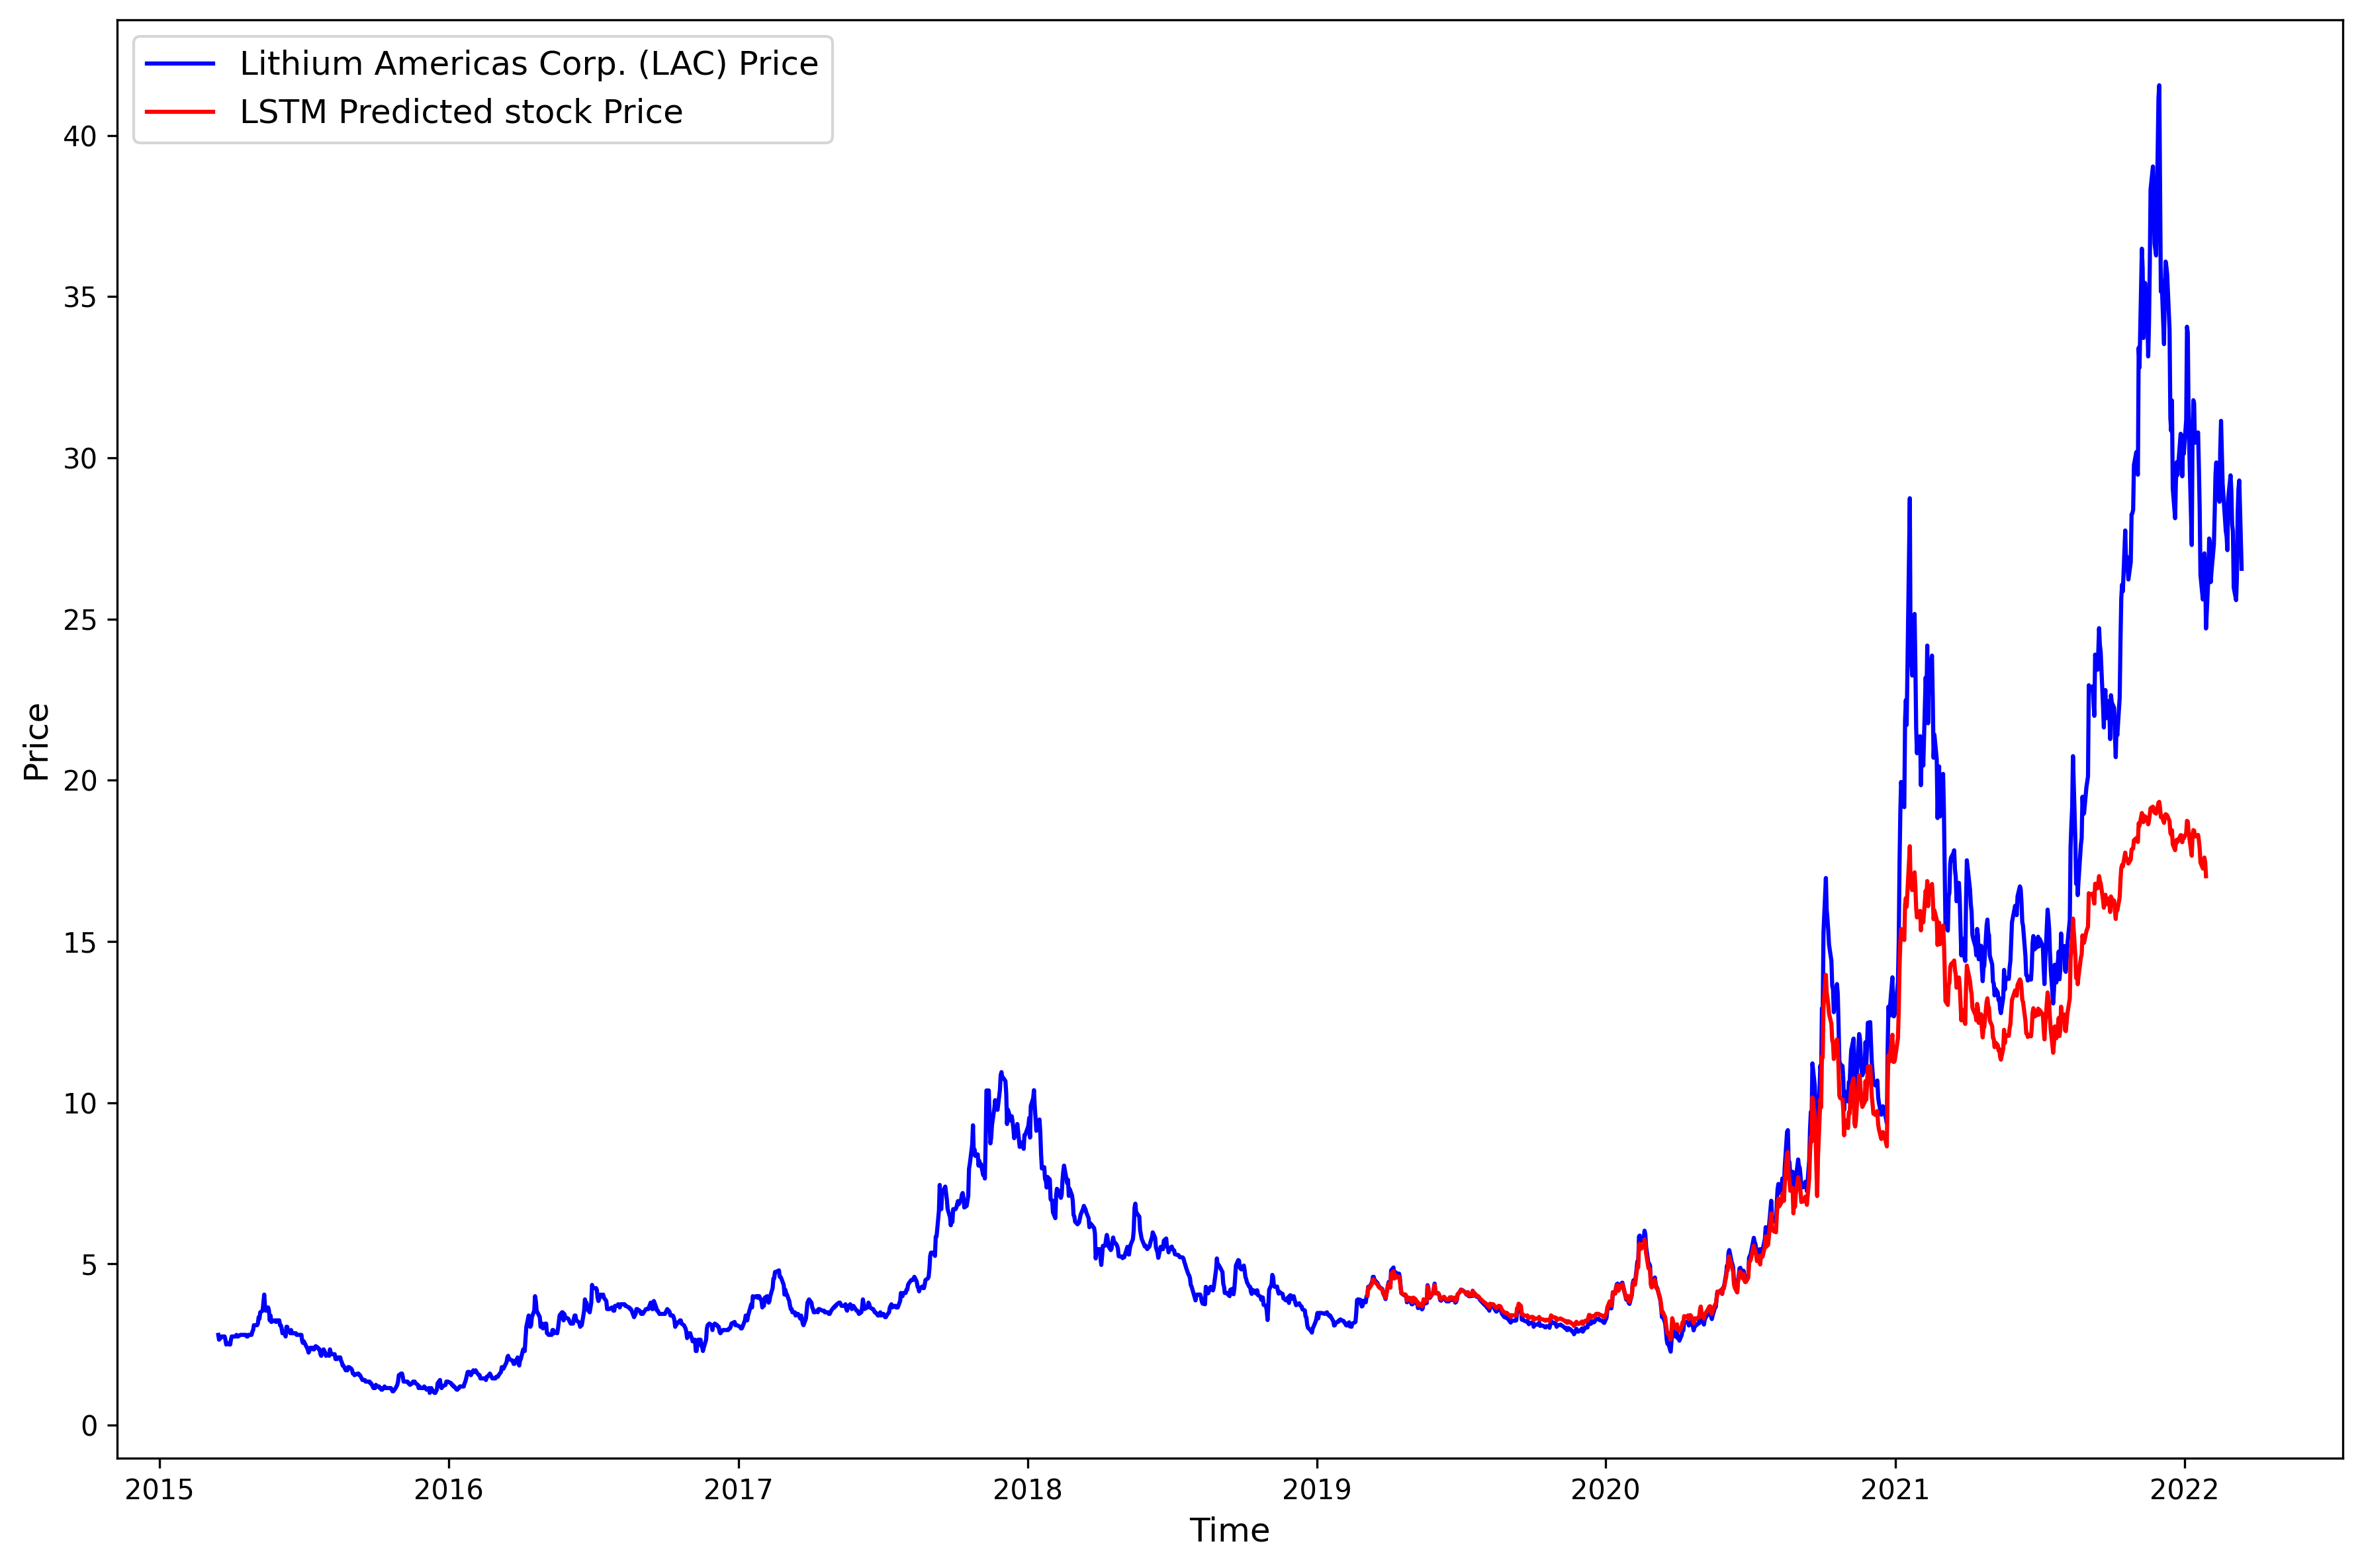

In [81]:
inputs=dataset[len(dataset_train)-days:]['High'].replace(',','', regex=True).astype(float)
inputs=np.array(inputs).reshape(-1,1)
inputs = sc.transform(inputs)

X_test=[]

for i in range (days,len(dataset_test)+days):
    X_test.append(inputs[i-days:i,0])

X_test=np.array(X_test)
X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

y_hat=model.predict(X_test)
Y_hat=sc.inverse_transform(y_hat[:,0])


Predictions = pd.DataFrame(Y_hat[0:,0], columns = ['y_hat'], index = index)
Predictions = Predictions.shift(-days).dropna()



plt.figure(figsize=(12,8), dpi=300)
plt.plot(dataset['High'].replace(',','', regex=True).astype(float), color='b', label= 'Lithium Americas Corp. (LAC) Price')
plt.plot(Predictions['y_hat'], color='r', label= 'LSTM Predicted stock Price')
plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('LAC Predicted Price', dpi=200);